# Business Case: Audiobook sales data

Case problem: Using a dataset with consumers data regarding purchase and consumption of Audiobooks from a given store, our goal is to predict if the customer will buy again in that store.
This is a classic classication problem where we must predict 1 (will buy again) or 0 (will not buy again).

### Relevant Imports

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# Training and Machine Learning algorithms
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

### Importing the dataset

In [2]:
df = pd.read_csv('audiobooks.csv')

In [3]:
df.head()

,ID,Book_length_avg,Book_length_overall,Price_avg,Price_overall,Review,Review_value,Completion_minperbook,Minutes_listened,Support_requests,Last_visit_minus_first_purchase,Target
0,994,1620.0,1620,19.73,19.73,1,10.00,0.99,1603.8,5,92,0
1,1143,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,0,0
2,2059,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,388,0
3,2882,1620.0,1620,5.96,5.96,0,8.91,0.42,680.4,1,129,0
4,3342,2160.0,2160,5.33,5.33,0,8.91,0.22,475.2,0,361,0


### Exploring the Data

First I will call the describe function to check how the data is distributed in terms of variance and to get the first insights about how we should start pre-processing it.

In [4]:
# Describe - stats from the df
df.describe()

,ID,Book_length_avg,Book_length_overall,Price_avg,Price_overall,Review,Review_value,Completion_minperbook,Minutes_listened,Support_requests,Last_visit_minus_first_purchase,Target
count,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000
mean,16772.491551,1591.281685,1678.608634,7.103791,7.543805,0.160750,8.909795,0.125659,189.888983,0.070222,61.935033,0.158833
std,9691.807248,504.340663,654.838599,4.931673,5.560129,0.367313,0.643406,0.241206,371.084010,0.472157,88.207634,0.365533
min,2.000000,216.000000,216.000000,3.860000,3.860000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8368.000000,1188.000000,1188.000000,5.330000,5.330000,0.000000,8.910000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16711.500000,1620.000000,1620.000000,5.950000,6.070000,0.000000,8.910000,0.000000,0.000000,0.000000,11.000000,0.000000
75%,25187.250000,2160.000000,2160.000000,8.000000,8.000000,0.000000,8.910000,0.130000,194.400000,0.000000,105.000000,0.000000
max,33683.000000,2160.000000,7020.000000,130.940000,130.940000,1.000000,10.000000,1.000000,2160.000000,30.000000,464.000000,1.000000


From the table above, it is possible to infer that an average user litens around 190 minutes of audiobooks in the plataform, we have many one time users, since the 'overall' and 'avg' columns show very similar values, most of the people don't leave Reviews, as that is a boolean column and the average is much closer to 0 (no Review). Finally, our dataset shows our 'conversion rate' at approx. 16% only = Col. Target mean.

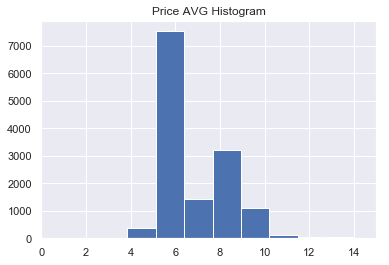

In [24]:
# Ploting histograms
plt.hist(df['Price_avg'], bins=100)
plt.xlim(0,15)
plt.title('Price AVG Histogram')
plt.show()

The Price average histograms shows that most of the users spend around 6USD (7k transactions), and 8USD is also a popular expense (3k transactions).

Let's create another column to check how many books the users usually download.
#Knowing the Price avg is the Price Overall divided by the total of sales, if we divide the price overall by the Price avg, we will have the sales number by client.

In [6]:
# Number of Sales new colum = Price overall/ Price avg
df2 = df.copy()
df2['number_sales'] = df2['Price_overall']/df2['Price_avg']
df2.number_sales.describe()

count    14084.000000
mean         1.063711
std          0.330958
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          7.001513
Name: number_sales, dtype: float64

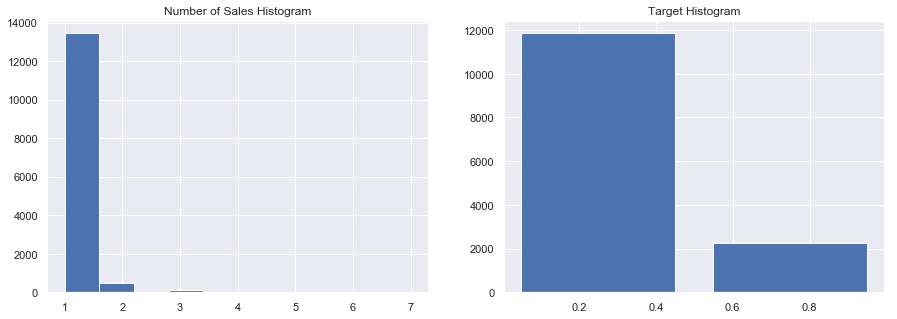

In [32]:
# Histogram Number of Sales
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.hist(df2['number_sales'])
ax1.set_title('Number of Sales Histogram')
ax2.hist(df2['Target'], bins=2, rwidth=0.8)
ax2.set_title('Target Histogram')
plt.show()

Knowing that almost all of the observations in the Price Avg histogram are in the range of 6 to 10 dollars and now seeing the Histograms with the Number of Sales and Target (Client converted or Not), we can confirm that most of the transactions are 'one time sales' for this company. So they are not converting enough.

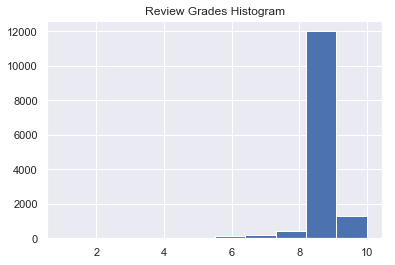

In [34]:
# Ploting histogram of the Reviews column
plt.hist(df['Review_value'])
plt.title('Review Grades Histogram')
plt.show()

Regarding the review grades, we can see that the dataset was preprocessed and had the mean included to the missing values, where the 'Review' columns equals to 0 (customer did not provide any review).

### Missing Values

In [42]:
# Checking for missing values in the dataset
df2.isnull().sum()

ID                                 0
Book_length_avg                    0
Book_length_overall                0
Price_avg                          0
Price_overall                      0
Review                             0
Review_value                       0
Completion_minperbook              0
Minutes_listened                   0
Support_requests                   0
Last_visit_minus_first_purchase    0
Target                             0
number_sales                       0
dtype: int64

### Feature Selection

I will drop a couple of columns, as I understand the bring the same information, just in a different way, so I believe that could cause impact in our model.
#I will remove the average columns: Book_length_avg, Price_avg and Completion_minperbook.

In [44]:
# Remove columns
cols_to_remove = ['Book_length_avg','Price_avg','Completion_minperbook']
df3 = df2.drop(cols_to_remove, axis=1)

### Imbalance Correction (weights)

Reviewing the Target Data, we can see that the dataset is really imbalanced. There are much more 0s than 1s. Let's correct that.

In [51]:
df3.Target.value_counts(normalize=True)

0    0.841167
1    0.158833
Name: Target, dtype: float64

As now we know that 16% is 1 and 84% is 0, let's add a weight column that will add an 84% weight to number 1 and 16% weight to number 0.

In [119]:
df4 = df3.copy()
weight = []
for n in range(len(df4)):
    if df4['Target'][n] == 1:
        weight.append(0.84)
    else:
        weight.append(0.16)

df4['weight'] = weight

In [120]:
# Rearrange columns
df4 = df4[['ID', 'Book_length_overall', 'Price_overall', 'Review', 'Review_value',
       'Minutes_listened', 'Support_requests',
       'Last_visit_minus_first_purchase', 'number_sales','weight','Target']]

In [122]:
df4.head(8)

,ID,Book_length_overall,Price_overall,Review,Review_value,Minutes_listened,Support_requests,Last_visit_minus_first_purchase,number_sales,weight,Target
0,994,1620,19.73,1,10.00,1603.8,5,92,1.0,0.16,0
1,1143,2160,5.33,0,8.91,0.0,0,0,1.0,0.16,0
2,2059,2160,5.33,0,8.91,0.0,0,388,1.0,0.16,0
3,2882,1620,5.96,0,8.91,680.4,1,129,1.0,0.16,0
4,3342,2160,5.33,0,8.91,475.2,0,361,1.0,0.16,0
5,3416,2160,4.61,0,8.91,0.0,0,0,1.0,0.16,0
6,4949,2160,5.33,0,8.91,86.4,0,366,1.0,0.16,0
7,9011,648,5.33,0,8.91,0.0,0,0,1.0,0.84,1


### Cross Validation for Model Selecion

In [124]:
# Dividing the dataset in X and y for cross-validation
X = df4.drop(['ID', 'Target'], axis=1)
y = df4.Target

In [135]:
#Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
stdX = scaler.transform(X)

In [129]:
# Creating an empty list of models to be tested
models =[]
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [134]:
# Creating lists to store the results
results =[]
names = []

#Creating a loop to test all the models
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1)
    cv_results = cross_val_score(model, stdX, y, cv = kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' %(name, cv_results.mean(), cv_results.std()))

LR: 1.000000 (0.000000)
KNN: 0.999077 (0.001007)
DTC: 1.000000 (0.000000)
NB: 1.000000 (0.000000)


## Model Creation and Training (Logistic Regression)

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Spliting the data in training and test
X_train, X_test, y_train, y_test = train_test_split(stdX, y, test_size=0.2, random_state=12)

In [137]:
# Model training
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [138]:
model.score(X_train, y_train)

1.0

A score of 1 (100%) is really uncommon and it looks like our model is overfitting the dataset. Let's see how it performs with the validation dataset.

In [142]:
# Predictions
pred = model.predict(X_test)

In [152]:
confusion=pd.DataFrame(confusion_matrix(y_test, pred), columns=['Predicted 0', 'Predicted 1'],
                       index=['Actual 0', 'Actual 1'])

In [153]:
confusion

,Predicted 0,Predicted 1
Actual 0,2332,0
Actual 1,0,485
